<a href="https://www.kaggle.com/code/zlatanshev/shevchenko-hp-kaggle?scriptVersionId=209998585" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [64]:
# Standard python libraries
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import optuna

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE

import plotly
import plotly.express as px

import category_encoders as ce

from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")

### Reading the data

In [2]:
train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
display(train_df.head())
display(train_df.shape)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

(1460, 81)

In [3]:
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
display(test_df.head())
display(test_df.shape)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

(1459, 80)

In [4]:
submission_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
submission_df.head()

Id      SalePrice
0  1461  169277.052498
1  1462  187758.393989
2  1463  183583.683570
3  1464  179317.477511
4  1465  150730.079977

### For the correct processing of features, we combine the train and the test into one dataset

In [5]:
train_df['sample'] = 1 # marking train
test_df['sample'] = 0 # marking test
test_df['SalePrice'] = 0 # editing target feature for test and fill it with 0

In [6]:
house_df = pd.concat([train_df,test_df], ignore_index=True).reset_index(drop=True)
display(house_df.head())
display(house_df.shape)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolQC Fence MiscFeature MiscVal MoSold YrSold  \
0         Lvl    AllPub  ...    NaN   NaN         NaN       0      2   2008   
1         Lvl    AllPub  ...    NaN   NaN         NaN       0      5   2007   
2         Lvl    AllPub  ...    NaN   NaN         NaN       0      9   2008   
3         Lvl    AllPub  ...    NaN   NaN         NaN       0      2   2006   
4         Lvl    AllPub  ...    NaN   NaN         NaN       0     12   2008   

  SaleType  SaleCondition  SalePrice  sample  
0       WD         Normal     208500       1  
1       WD         Normal     181500       1  
2       WD         Normal     223500       1  
3       WD        Abnorml     140000       1  
4       WD         Normal     250000       1  

[5 rows x 82 columns]

(2919, 82)

In [7]:
dupl_columns = list(house_df.columns)

mask = house_df.duplicated(subset=dupl_columns)
house_duplicates = house_df[mask]
print(f'Number of dublicates: {house_duplicates.shape[0]}')

Number of dublicates: 0


### Calculate the percentage of identical and unique values, delete over threshold

In [8]:
low_information_cols = [] 

#cycle through all columns
for col in house_df.columns:
    #the highest relative frequency in the feature
    top_freq = house_df[col].value_counts(normalize=True).max()
    #the proportion of unique values from the size of the feature
    nunique_ratio = house_df[col].nunique() / house_df[col].count()
    # compare the highest frequency with the threshold
    if top_freq > 0.7:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% identical values')
        house_df = house_df.drop(col,axis=1)
    # compare the unique frequency with the threshold
    if nunique_ratio > 0.7:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% unique values')
        house_df = house_df.drop(col,axis=1)
len(low_information_cols)


Id: 100.0% unique values
MSZoning: 77.7% identical values
Street: 99.59% identical values
LandContour: 89.83% identical values
Utilities: 99.97% identical values
LotConfig: 73.07% identical values
LandSlope: 95.17% identical values
Condition1: 86.02% identical values
Condition2: 98.97% identical values
BldgType: 83.08% identical values
RoofStyle: 79.14% identical values
RoofMatl: 98.53% identical values
MasVnrType: 76.24% identical values
ExterCond: 86.95% identical values
BsmtCond: 91.86% identical values
BsmtFinType2: 87.81% identical values
BsmtFinSF2: 88.11% identical values
Heating: 98.46% identical values
CentralAir: 93.29% identical values
Electrical: 91.54% identical values
LowQualFinSF: 98.63% identical values
BsmtHalfBath: 94.0% identical values
KitchenAbvGr: 95.41% identical values
Functional: 93.14% identical values
GarageQual: 94.35% identical values
GarageCond: 96.16% identical values
PavedDrive: 90.48% identical values
EnclosedPorch: 84.28% identical values
3SsnPorch: 98

35

In [9]:
house_df.describe()

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  2919.000000  2433.000000    2919.000000  2919.000000  2919.000000   
mean     57.137718    69.305795   10168.114080     6.089072     5.564577   
std      42.517628    23.344905    7886.996359     1.409947     1.113131   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7478.000000     5.000000     5.000000   
50%      50.000000    68.000000    9453.000000     6.000000     5.000000   
75%      70.000000    80.000000   11570.000000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1    BsmtUnfSF  ...  \
count  2919.000000   2919.000000  2896.000000  2918.000000  2918.000000  ...   
mean   1971.312778   1984.264474   102.201312   441.423235   560.772104  ...   
std      30.291442     20.894344   179.334253   455.610826   439.543659  ...   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000  ...   
25%    1953.500000   1965.000000     0.000000     0.000000   220.000000  ...   
50%    1973.000000   1993.000000     0.000000   368.500000   467.000000  ...   
75%    2001.000000   2004.000000   164.000000   733.000000   805.500000  ...   
max    2010.000000   2010.000000  1600.000000  5644.000000  2336.000000  ...   

        Fireplaces  GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  \
count  2919.000000  2760.000000  2918.000000  2918.000000  2919.000000   
mean      0.597122  1978.113406     1.766621   472.874572    93.709832   
std       0.646129    25.574285     0.761624   215.394815   126.526589   
min       0.000000  1895.000000     0.000000     0.000000     0.000000   
25%       0.000000  1960.000000     1.000000   320.000000     0.000000   
50%       1.000000  1979.000000     2.000000   480.000000     0.000000   
75%       1.000000  2002.000000     2.000000   576.000000   168.000000   
max       4.000000  2207.000000     5.000000  1488.000000  1424.000000   

       OpenPorchSF       MoSold       YrSold      SalePrice       sample  
count  2919.000000  2919.000000  2919.000000    2919.000000  2919.000000  
mean     47.486811     6.213087  2007.792737   90491.588215     0.500171  
std      67.575493     2.714762     1.314964  106496.379333     0.500086  
min       0.000000     1.000000  2006.000000       0.000000     0.000000  
25%       0.000000     4.000000  2007.000000       0.000000     0.000000  
50%      26.000000     6.000000  2008.000000   34900.000000     1.000000  
75%      70.000000     8.000000  2009.000000  163000.000000     1.000000  
max     742.000000    12.000000  2010.000000  755000.000000     1.000000  

[8 rows x 29 columns]

In [10]:
house_df.describe(include='object')

Alley LotShape Neighborhood HouseStyle Exterior1st Exterior2nd  \
count    198     2919         2919       2919        2918        2918   
unique     2        4           25          8          15          16   
top     Grvl      Reg        NAmes     1Story     VinylSd     VinylSd   
freq     120     1859          443       1471        1025        1014   

       ExterQual Foundation BsmtQual BsmtExposure BsmtFinType1 HeatingQC  \
count       2919       2919     2838         2837         2840      2919   
unique         4          6        4            4            6         5   
top           TA      PConc       TA           No          Unf        Ex   
freq        1798       1308     1283         1904          851      1493   

       KitchenQual FireplaceQu GarageType GarageFinish PoolQC  Fence  
count         2918        1499       2762         2760     10    571  
unique           4           5          6            3      3      4  
top             TA          Gd     Attchd          Unf     Ex  MnPrv  
freq          1492         744       1723         1230      4    329

In [11]:
# get number of nulls in all features
missing_values = house_df.isnull().sum()

# creating a dictionary only for those features where the number of nuuls > zero
missing_dict = {column: count for column, count in missing_values.items() if count > 0}

# get sorted features and nulls
print(sorted(missing_dict.items(), key=lambda x: x[1], reverse=True))

[('PoolQC', 2909), ('Alley', 2721), ('Fence', 2348), ('FireplaceQu', 1420), ('LotFrontage', 486), ('GarageYrBlt', 159), ('GarageFinish', 159), ('GarageType', 157), ('BsmtExposure', 82), ('BsmtQual', 81), ('BsmtFinType1', 79), ('MasVnrArea', 23), ('BsmtFullBath', 2), ('Exterior1st', 1), ('Exterior2nd', 1), ('BsmtFinSF1', 1), ('BsmtUnfSF', 1), ('TotalBsmtSF', 1), ('KitchenQual', 1), ('GarageCars', 1), ('GarageArea', 1)]


In [12]:
# displaying features with zeros as a percentage of the main dataframe
percentage_nulls = {column: ((count/house_df.shape[0]) * 100) for column, count in missing_values.items() if count > 0}
percentage_nulls

{'LotFrontage': 16.649537512846866,
 'Alley': 93.21685508735868,
 'Exterior1st': 0.0342583076396026,
 'Exterior2nd': 0.0342583076396026,
 'MasVnrArea': 0.7879410757108599,
 'BsmtQual': 2.774922918807811,
 'BsmtExposure': 2.8091812264474134,
 'BsmtFinType1': 2.7064063035286057,
 'BsmtFinSF1': 0.0342583076396026,
 'BsmtUnfSF': 0.0342583076396026,
 'TotalBsmtSF': 0.0342583076396026,
 'BsmtFullBath': 0.0685166152792052,
 'KitchenQual': 0.0342583076396026,
 'FireplaceQu': 48.646796848235695,
 'GarageType': 5.378554299417608,
 'GarageYrBlt': 5.4470709146968135,
 'GarageFinish': 5.4470709146968135,
 'GarageCars': 0.0342583076396026,
 'GarageArea': 0.0342583076396026,
 'PoolQC': 99.65741692360398,
 'Fence': 80.4385063377869}

In [13]:
# get features with over 25 %
lst_big_nulls = []
for k, v in percentage_nulls.items():
    if v > 25:
        lst_big_nulls.append(k)


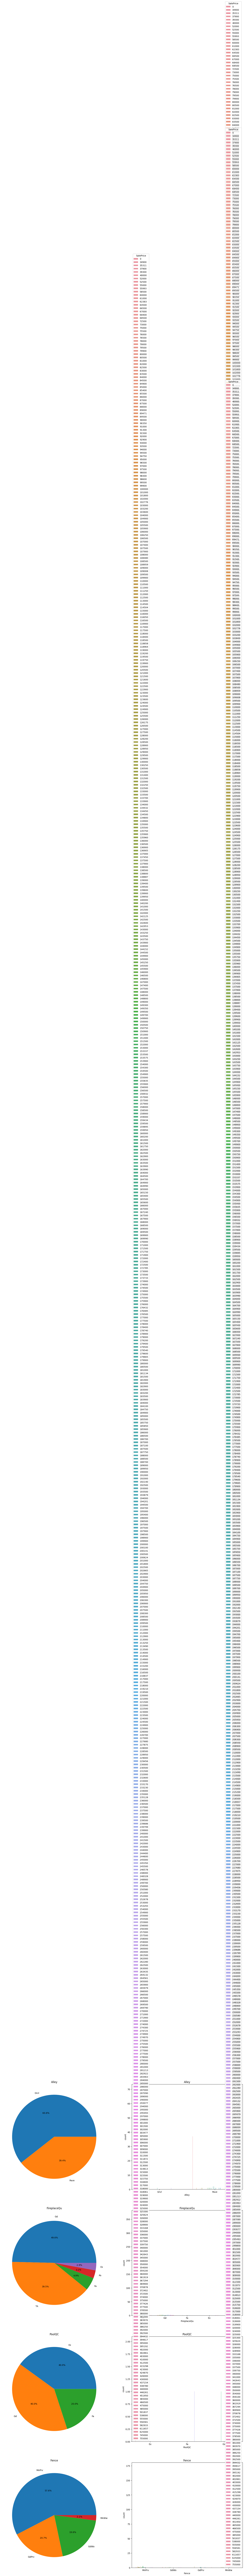

In [14]:
#Visualisation for features with over 25 % of nulls
n = len(lst_big_nulls) #number of features
fig, axes = plt.subplots(n, 2, figsize=(20, 40)) #figure+n*2 coordinate planes
for i, feature in enumerate(lst_big_nulls):
    #build a pie for the percentage of each of the feature
    count_data = house_df[feature].value_counts().rename(feature)
    axes[i][0].pie(count_data, autopct='%.1f%%', labels=count_data.index)
    axes[i][0].set_title(feature)
    #build bar charts to demonstrate the dependence of each feature on the target
    sns.countplot(data=house_df, x=feature, hue='SalePrice', ax=axes[i][1])
    axes[i][1].set_title(feature)
plt.tight_layout() #alignment of graphs

In [15]:
house_df = house_df.drop(lst_big_nulls, axis=1)

In [16]:
feature_nulls = house_df.isnull().sum()
feature_nulls

MSSubClass        0
LotFrontage     486
LotArea           0
LotShape          0
Neighborhood      0
HouseStyle        0
OverallQual       0
OverallCond       0
YearBuilt         0
YearRemodAdd      0
Exterior1st       1
Exterior2nd       1
MasVnrArea       23
ExterQual         0
Foundation        0
BsmtQual         81
BsmtExposure     82
BsmtFinType1     79
BsmtFinSF1        1
BsmtUnfSF         1
TotalBsmtSF       1
HeatingQC         0
1stFlrSF          0
2ndFlrSF          0
GrLivArea         0
BsmtFullBath      2
FullBath          0
HalfBath          0
BedroomAbvGr      0
KitchenQual       1
TotRmsAbvGrd      0
Fireplaces        0
GarageType      157
GarageYrBlt     159
GarageFinish    159
GarageCars        1
GarageArea        1
WoodDeckSF        0
OpenPorchSF       0
MoSold            0
YrSold            0
SalePrice         0
sample            0
dtype: int64

### Let's highlight the features with large and small nulls in the data

In [17]:
big_null_values = []
small_null_values = []
for key, value in feature_nulls.items():
    if value > 2:
        big_null_values.append(key)
    elif value <= 2 and value != 0:
        small_null_values.append(key)

In [18]:
display(house_df[small_null_values])
display(house_df[small_null_values].info())

Exterior1st Exterior2nd  BsmtFinSF1  BsmtUnfSF  TotalBsmtSF  \
0        VinylSd     VinylSd       706.0      150.0        856.0   
1        MetalSd     MetalSd       978.0      284.0       1262.0   
2        VinylSd     VinylSd       486.0      434.0        920.0   
3        Wd Sdng     Wd Shng       216.0      540.0        756.0   
4        VinylSd     VinylSd       655.0      490.0       1145.0   
...          ...         ...         ...        ...          ...   
2914     CemntBd     CmentBd         0.0      546.0        546.0   
2915     CemntBd     CmentBd       252.0      294.0        546.0   
2916     VinylSd     VinylSd      1224.0        0.0       1224.0   
2917     HdBoard     Wd Shng       337.0      575.0        912.0   
2918     HdBoard     HdBoard       758.0      238.0        996.0   

      BsmtFullBath KitchenQual  GarageCars  GarageArea  
0              1.0          Gd         2.0       548.0  
1              0.0          TA         2.0       460.0  
2              1.0          Gd         2.0       608.0  
3              1.0          Gd         3.0       642.0  
4              1.0          Gd         3.0       836.0  
...            ...         ...         ...         ...  
2914           0.0          TA         0.0         0.0  
2915           0.0          TA         1.0       286.0  
2916           1.0          TA         2.0       576.0  
2917           0.0          TA         0.0         0.0  
2918           0.0          TA         3.0       650.0  

[2919 rows x 9 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Exterior1st   2918 non-null   object 
 1   Exterior2nd   2918 non-null   object 
 2   BsmtFinSF1    2918 non-null   float64
 3   BsmtUnfSF     2918 non-null   float64
 4   TotalBsmtSF   2918 non-null   float64
 5   BsmtFullBath  2917 non-null   float64
 6   KitchenQual   2918 non-null   object 
 7   GarageCars    2918 non-null   float64
 8   GarageArea    2918 non-null   float64
dtypes: float64(6), object(3)
memory usage: 205.4+ KB


None

### Fillna small null values

In [19]:
house_df['Exterior1st'] = house_df['Exterior1st'].fillna(house_df['Exterior1st'].mode()[0])
house_df['Exterior2nd'] = house_df['Exterior2nd'].fillna(house_df['Exterior2nd'].mode()[0])
house_df['BsmtFullBath'] = house_df['BsmtFullBath'].fillna(house_df['BsmtFullBath'].mode()[0])
house_df['KitchenQual'] = house_df['KitchenQual'].fillna(house_df['KitchenQual'].mode()[0])
house_df['GarageCars'] = house_df['GarageCars'].fillna(house_df['GarageCars'].mode()[0])

house_df['BsmtFinSF1'] = house_df['BsmtFinSF1'].fillna(house_df['BsmtFinSF1'].median())
house_df['BsmtUnfSF'] = house_df['BsmtUnfSF'].fillna(house_df['BsmtUnfSF'].median())
house_df['TotalBsmtSF'] = house_df['TotalBsmtSF'].fillna(house_df['TotalBsmtSF'].median())
house_df['GarageArea'] = house_df['GarageArea'].fillna(house_df['GarageArea'].median())

In [20]:
for feature in big_null_values:
    display('{} - {} '.format(feature, house_df[feature].dtype))

'LotFrontage - float64 '

'MasVnrArea - float64 '

'BsmtQual - object '

'BsmtExposure - object '

'BsmtFinType1 - object '

'GarageType - object '

'GarageYrBlt - float64 '

'GarageFinish - object '

### Let's divide the features into numerical and categorical ones

In [21]:
numeric_predict_null = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
cat_predict_null = ['BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'GarageType', 'GarageFinish']

## Fill the nulls with the predicted values

### Let's prepare the data for prediction

In [22]:
def encode_cat_features(columns_to_change, X_train, X_test, y_train):
    for column in columns_to_change:
        X_train[column].fillna('unknown', inplace=True)
        X_test[column].fillna('unknown', inplace=True)
    one_hot_encoder = preprocessing.OneHotEncoder(handle_unknown='ignore')
    X_train_onehot = one_hot_encoder.fit_transform(X_train[columns_to_change]).toarray()
    X_test_onehot = one_hot_encoder.transform(X_test[columns_to_change]).toarray()

    columns = one_hot_encoder.get_feature_names_out(columns_to_change)
    
    X_train_onehot_df = pd.DataFrame(X_train_onehot, columns=columns)
    X_test_onehot_df = pd.DataFrame(X_test_onehot, columns=columns)
    
    X_train = X_train.reset_index().drop(['index'], axis = 1)
    X_test = X_test.reset_index().drop(['index'], axis = 1)
    y_train = y_train.reset_index().drop(['index'], axis = 1)

    X_train_new = pd.concat([X_train, X_train_onehot_df], axis=1)
    X_test_new = pd.concat([X_test, X_test_onehot_df], axis=1)
    
    X_train_new = X_train_new.drop(columns=columns_to_change)
    X_test_new = X_test_new.drop(columns=columns_to_change)

    return X_train_new, X_test_new

In [23]:
categorial_cols = ['LotShape', 'Neighborhood', 'HouseStyle', 'Exterior1st', 'Exterior2nd', 'ExterQual', 
                   'Foundation', 'HeatingQC', 'KitchenQual']

In [24]:
big_null_values

['LotFrontage',
 'MasVnrArea',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish']

### And the prediction function for numeric features

In [25]:
data = house_df.copy()
def predicting_nulls_numeric(data, feature_lst):
    for feature in feature_lst:
        print(feature)
    # As a test sample, let's take the features with nulls
        test_data = data[data[feature].isnull()]
    # And delete these lines from data
        data_cleaned = data.dropna(subset=[feature])
    # Let's define the target feature and factors
        y_train = data_cleaned[feature]
        X_train = data_cleaned.drop(big_null_values, axis=1)
        X_test = test_data.drop(big_null_values, axis=1)
    
        X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test, y_train)
    # fit the model
        model = LinearRegression()
        model.fit(X_train_new, y_train)
 
        y_pred = model.predict(X_test_new)
        y_pred
    
        for i, ni in enumerate(test_data.index):
            data.loc[ni, feature] = y_pred[i]
    return data
    

In [26]:
df_pred_nulls = predicting_nulls_numeric(data, numeric_predict_null)

LotFrontage
MasVnrArea
GarageYrBlt


### Prediction function for categorical features

In [27]:
def predicting_nulls_cat(data, feature_lst):
    for feature in feature_lst:
        print(feature)
    # As a test sample, let's take the features with nulls
        test_data = data[data[feature].isnull()]
    # And delete these lines from data
        data_cleaned = data.dropna(subset=[feature])
    # Let's define the target feature and factors
        y_train = data_cleaned[feature]
        X_train = data_cleaned.drop(big_null_values, axis=1)
        X_test = test_data.drop(big_null_values, axis=1)
    
        X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test, y_train)

    # fit the model
        model = LogisticRegression(
        multi_class='multinomial', 
        max_iter=1000, 
        random_state=42 
        )
        model.fit(X_train_new, y_train)
 
        y_pred = model.predict(X_test_new)
        y_pred.shape
    
        for i, ni in enumerate(test_data.index):
            data.loc[ni, feature] = y_pred[i]
    return data

In [28]:
df_pred_cat = predicting_nulls_cat(df_pred_nulls, cat_predict_null)

BsmtQual
BsmtExposure
BsmtFinType1
GarageType
GarageFinish


In [29]:
house_df.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'LotShape', 'Neighborhood',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual', 'Foundation',
       'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'MoSold', 'YrSold', 'SalePrice', 'sample'],
      dtype='object')

In [30]:
df_pred_cat.isnull().sum().sort_values(ascending=False)

MSSubClass      0
GarageType      0
GrLivArea       0
BsmtFullBath    0
FullBath        0
HalfBath        0
BedroomAbvGr    0
KitchenQual     0
TotRmsAbvGrd    0
Fireplaces      0
GarageYrBlt     0
1stFlrSF        0
GarageFinish    0
GarageCars      0
GarageArea      0
WoodDeckSF      0
OpenPorchSF     0
MoSold          0
YrSold          0
SalePrice       0
2ndFlrSF        0
HeatingQC       0
LotFrontage     0
Exterior1st     0
LotArea         0
LotShape        0
Neighborhood    0
HouseStyle      0
OverallQual     0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
Exterior2nd     0
TotalBsmtSF     0
MasVnrArea      0
ExterQual       0
Foundation      0
BsmtQual        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinSF1      0
BsmtUnfSF       0
sample          0
dtype: int64

In [31]:
house_df = df_pred_cat.copy()

### Creating new features

In [32]:
house_df['Age_house'] = house_df['YrSold'] - house_df['YearBuilt']
house_df['finishedSFBA'] = house_df['TotalBsmtSF'] - house_df['BsmtUnfSF']
house_df['allhouseSF'] = house_df['1stFlrSF'] + house_df['2ndFlrSF']

In [33]:
# converting the age feature to the object type
house_df['Age_house'] = pd.cut(house_df['Age_house'], [0, 10, 20, 30, 40 , 50, 60, 70, 80, 9999], labels = ['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '80-90', '+90']).astype('object')

In [34]:
house_df['Age_house'] = house_df['Age_house'].apply(lambda x: '0' if pd.isna(x) else x)

In [35]:
house_df['TotalSF'] = house_df['TotalBsmtSF'] + house_df['1stFlrSF'] + house_df['2ndFlrSF']

In [36]:
cat_features_to_preproc_dummies = ['HouseStyle', 'Foundation', 'GarageType']
cat_features_to_preproc_label = ['LotShape', 'ExterQual', 'HeatingQC', 'KitchenQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'Age_house']
cat_features_to_preproc_binary = ['Neighborhood', 'Exterior1st', 'Exterior2nd', 'MSSubClass']

In [37]:
# converting object type features 
label_encoder = preprocessing.LabelEncoder()
one_hot_encoder = preprocessing.OneHotEncoder()

for feature in cat_features_to_preproc_label:
    house_df[feature] = label_encoder.fit_transform(house_df[feature])

bin_encoder = ce.BinaryEncoder(cols=cat_features_to_preproc_binary) 
type_bin = bin_encoder.fit_transform(house_df[cat_features_to_preproc_binary])
house_df = pd.concat([house_df, type_bin], axis=1)

house_df = pd.get_dummies(house_df, columns=cat_features_to_preproc_dummies, dtype='int64')
        

In [38]:
# delete previously converted features
house_df= house_df.drop(['Neighborhood', 'Exterior1st', 'Exterior2nd', 'MSSubClass'], axis=1)

In [39]:
house_df.head()

LotFrontage  LotArea  LotShape  OverallQual  OverallCond  YearBuilt  \
0         65.0     8450         3            7            5       2003   
1         80.0     9600         3            6            8       1976   
2         68.0    11250         0            7            5       2001   
3         60.0     9550         0            7            5       1915   
4         84.0    14260         0            8            5       2000   

   YearRemodAdd  MasVnrArea  ExterQual  BsmtQual  ...  Foundation_PConc  \
0          2003       196.0          2         2  ...                 1   
1          1976         0.0          3         2  ...                 0   
2          2002       162.0          2         2  ...                 1   
3          1970         0.0          3         3  ...                 0   
4          2000       350.0          2         2  ...                 1   

   Foundation_Slab  Foundation_Stone  Foundation_Wood  GarageType_2Types  \
0                0                 0                0                  0   
1                0                 0                0                  0   
2                0                 0                0                  0   
3                0                 0                0                  0   
4                0                 0                0                  0   

   GarageType_Attchd  GarageType_Basment  GarageType_BuiltIn  \
0                  1                   0                   0   
1                  1                   0                   0   
2                  1                   0                   0   
3                  0                   0                   0   
4                  1                   0                   0   

   GarageType_CarPort  GarageType_Detchd  
0                   0                  0  
1                   0                  0  
2                   0                  0  
3                   0                  1  
4                   0                  0  

[5 rows x 79 columns]

In [40]:
# creating list of numeric features
features_to_hist = house_df.nunique()[house_df.nunique() > 20]
features_to_hist.index

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'SalePrice', 'finishedSFBA', 'allhouseSF', 'TotalSF'],
      dtype='object')

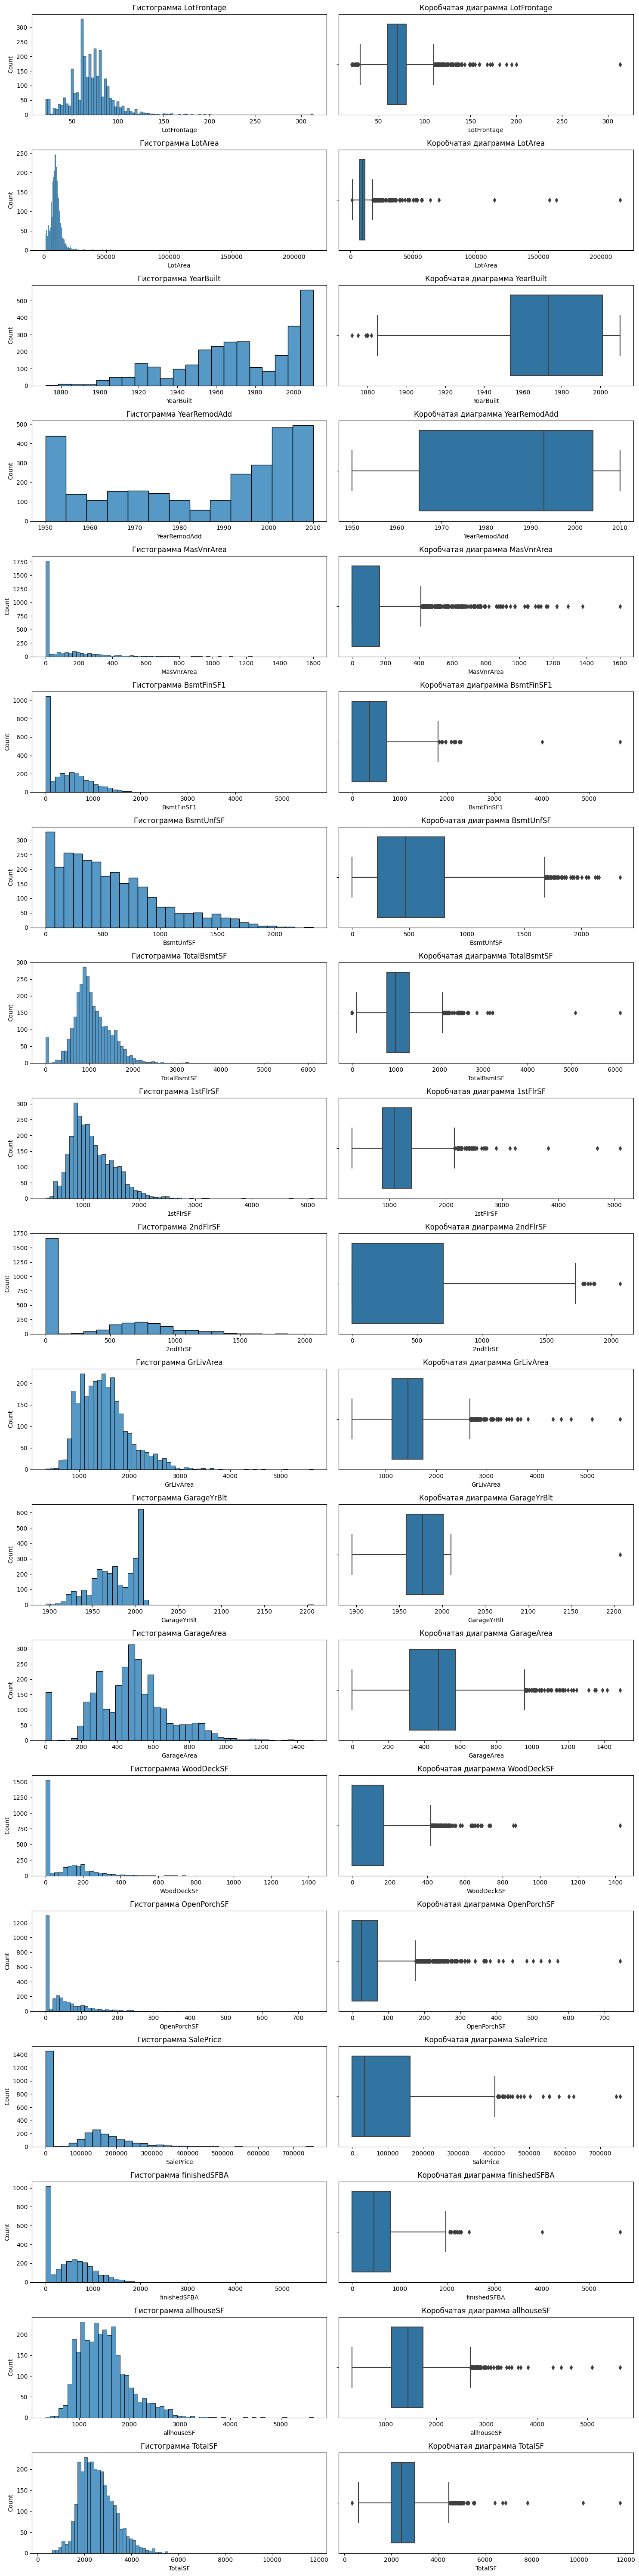

In [41]:
#Visualisation for numeric features
n = len(features_to_hist.index) #number of features
fig, axes = plt.subplots(n, 2, figsize=(15, 60)) #figure+n*2 coordinate planes
for i, feature in enumerate(features_to_hist.index):
    #build a pie for the percentage of each of the feature
    hisplot = sns.histplot(house_df, x=feature, ax=axes[i][0]);
    hisplot.set_title('Гистограмма {}'.format(feature))
    #build bar charts to demonstrate the dependence of each feature on the target
    boxplot = sns.boxplot(house_df, x=feature, ax=axes[i][1]);
    boxplot.set_title('Коробчатая диаграмма {}'.format(feature))
plt.tight_layout() #alignment of graphs

### Selecting a test sample from the data

In [42]:
new_test_df = house_df.loc[house_df['sample'] == 0].drop(['sample'], axis=1)
print(test_df.shape)
print(new_test_df.shape)

(1459, 82)
(1459, 78)


In [44]:
house_df.describe()

LotFrontage        LotArea     LotShape  OverallQual  OverallCond  \
count   2919.00000    2919.000000  2919.000000  2919.000000  2919.000000   
mean      70.27909   10168.114080     1.947585     6.089072     5.564577   
std       22.52823    7886.996359     1.409721     1.409947     1.113131   
min       21.00000    1300.000000     0.000000     1.000000     1.000000   
25%       60.00000    7478.000000     0.000000     5.000000     5.000000   
50%       70.00000    9453.000000     3.000000     6.000000     5.000000   
75%       80.00000   11570.000000     3.000000     7.000000     6.000000   
max      313.00000  215245.000000     3.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea    ExterQual     BsmtQual  ...  \
count  2919.000000   2919.000000  2919.000000  2919.000000  2919.000000  ...   
mean   1971.312778   1984.264474   102.465787     2.530661     2.255224  ...   
std      30.291442     20.894344   178.912187     0.702245     0.886433  ...   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000  ...   
25%    1953.500000   1965.000000     0.000000     2.000000     2.000000  ...   
50%    1973.000000   1993.000000     0.000000     3.000000     2.000000  ...   
75%    2001.000000   2004.000000   164.500000     3.000000     3.000000  ...   
max    2010.000000   2010.000000  1600.000000     3.000000     3.000000  ...   

       Foundation_PConc  Foundation_Slab  Foundation_Stone  Foundation_Wood  \
count       2919.000000      2919.000000       2919.000000      2919.000000   
mean           0.448099         0.016787          0.003768         0.001713   
std            0.497384         0.128493          0.061282         0.041359   
min            0.000000         0.000000          0.000000         0.000000   
25%            0.000000         0.000000          0.000000         0.000000   
50%            0.000000         0.000000          0.000000         0.000000   
75%            1.000000         0.000000          0.000000         0.000000   
max            1.000000         1.000000          1.000000         1.000000   

       GarageType_2Types  GarageType_Attchd  GarageType_Basment  \
count        2919.000000        2919.000000         2919.000000   
mean            0.007879           0.611511            0.012676   
std             0.088431           0.487490            0.111889   
min             0.000000           0.000000            0.000000   
25%             0.000000           0.000000            0.000000   
50%             0.000000           1.000000            0.000000   
75%             0.000000           1.000000            0.000000   
max             1.000000           1.000000            1.000000   

       GarageType_BuiltIn  GarageType_CarPort  GarageType_Detchd  
count         2919.000000         2919.000000        2919.000000  
mean             0.063720            0.005139           0.299075  
std              0.244296            0.071513           0.457931  
min              0.000000            0.000000           0.000000  
25%              0.000000            0.000000           0.000000  
50%              0.000000            0.000000           0.000000  
75%              0.000000            0.000000           1.000000  
max              1.000000            1.000000           1.000000  

[8 rows x 79 columns]

In [45]:
house_df.isna().sum().nlargest(20)

LotFrontage     0
LotArea         0
LotShape        0
OverallQual     0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
MasVnrArea      0
ExterQual       0
BsmtQual        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinSF1      0
BsmtUnfSF       0
TotalBsmtSF     0
HeatingQC       0
1stFlrSF        0
2ndFlrSF        0
GrLivArea       0
BsmtFullBath    0
dtype: int64

### Identifying outliers in the data

In [46]:
# Z range test
def outliers_z_score(data, feature_lst, log_scale=False):
    for feature in feature_lst:
        print(feature)
        if log_scale:
            x = np.log(data[feature]+1)
        else:
            x = data[feature]
        mu = x.mean()
        sigma = x.std()
        lower_bound = mu - 3 * sigma
        print('lower bound: {}'.format(round(lower_bound)))
        upper_bound = mu + 3 * sigma
        print('upper_bound: {}'.format(round(upper_bound)))
        outliers = data[(x < lower_bound) | (x > upper_bound)]
        cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
        print('Number of outliers after z-deviation method in {}: {}'.format(feature, outliers.shape[0]))
        print('The resulting number of records in {}: {}'.format(feature, cleaned.shape[0]))
        print('')
        data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]

    return data

house_df_cleaned = outliers_z_score(house_df, features_to_hist.index, log_scale=False)


LotFrontage
lower bound: 3
upper_bound: 138
Number of outliers after z-deviation method in LotFrontage: 26
The resulting number of records in LotFrontage: 2893

LotArea
lower bound: -5438
upper_bound: 25164
Number of outliers after z-deviation method in LotArea: 37
The resulting number of records in LotArea: 2856

YearBuilt
lower bound: 1880
upper_bound: 2063
Number of outliers after z-deviation method in YearBuilt: 7
The resulting number of records in YearBuilt: 2849

YearRemodAdd
lower bound: 1922
upper_bound: 2047
Number of outliers after z-deviation method in YearRemodAdd: 0
The resulting number of records in YearRemodAdd: 2849

MasVnrArea
lower bound: -419
upper_bound: 621
Number of outliers after z-deviation method in MasVnrArea: 61
The resulting number of records in MasVnrArea: 2788

BsmtFinSF1
lower bound: -846
upper_bound: 1694
Number of outliers after z-deviation method in BsmtFinSF1: 12
The resulting number of records in BsmtFinSF1: 2776

BsmtUnfSF
lower bound: -751
upper_bo

In [47]:
print(house_df.shape)
print(house_df_cleaned.shape)

(2919, 79)
(2603, 79)


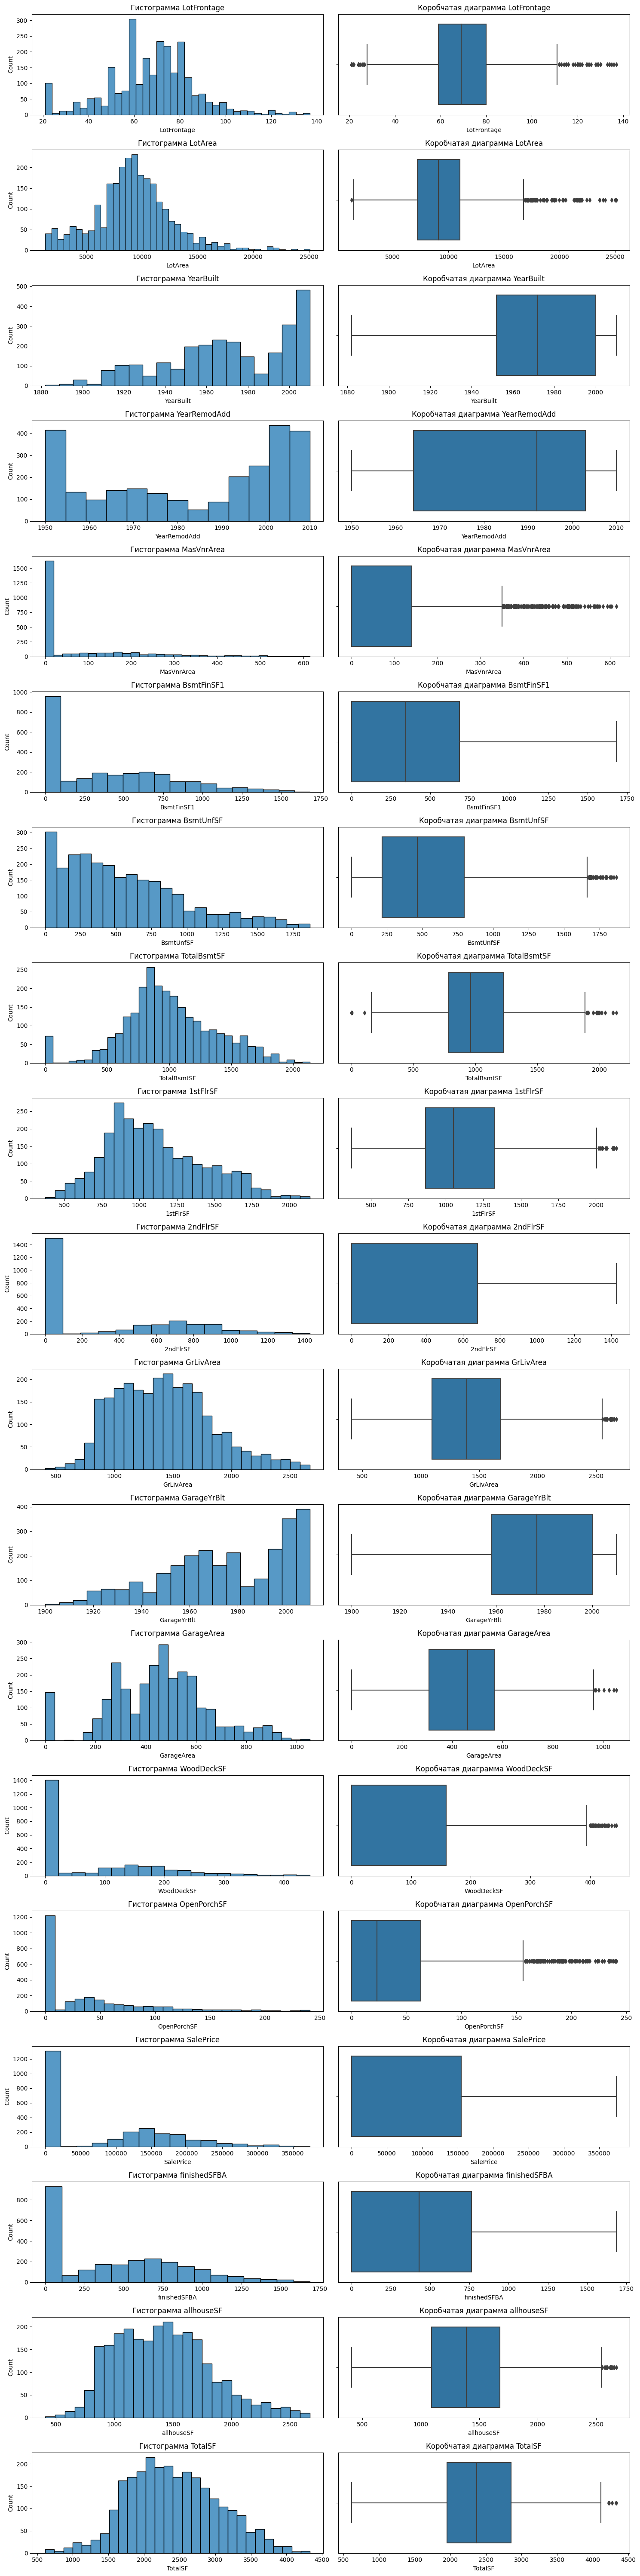

In [48]:
#Visualisation for numeric features
n = len(features_to_hist.index) #number of features
fig, axes = plt.subplots(n, 2, figsize=(15, 60)) #figure+n*2 coordinate planes
for i, feature in enumerate(features_to_hist.index):
    #build a pie for the percentage of each of the feature
    hisplot = sns.histplot(house_df_cleaned, x=feature, ax=axes[i][0]);
    hisplot.set_title('Гистограмма {}'.format(feature))
    #build bar charts to demonstrate the dependence of each feature on the target
    boxplot = sns.boxplot(house_df_cleaned, x=feature, ax=axes[i][1]);
    boxplot.set_title('Коробчатая диаграмма {}'.format(feature))
plt.tight_layout() #alignment of graphs

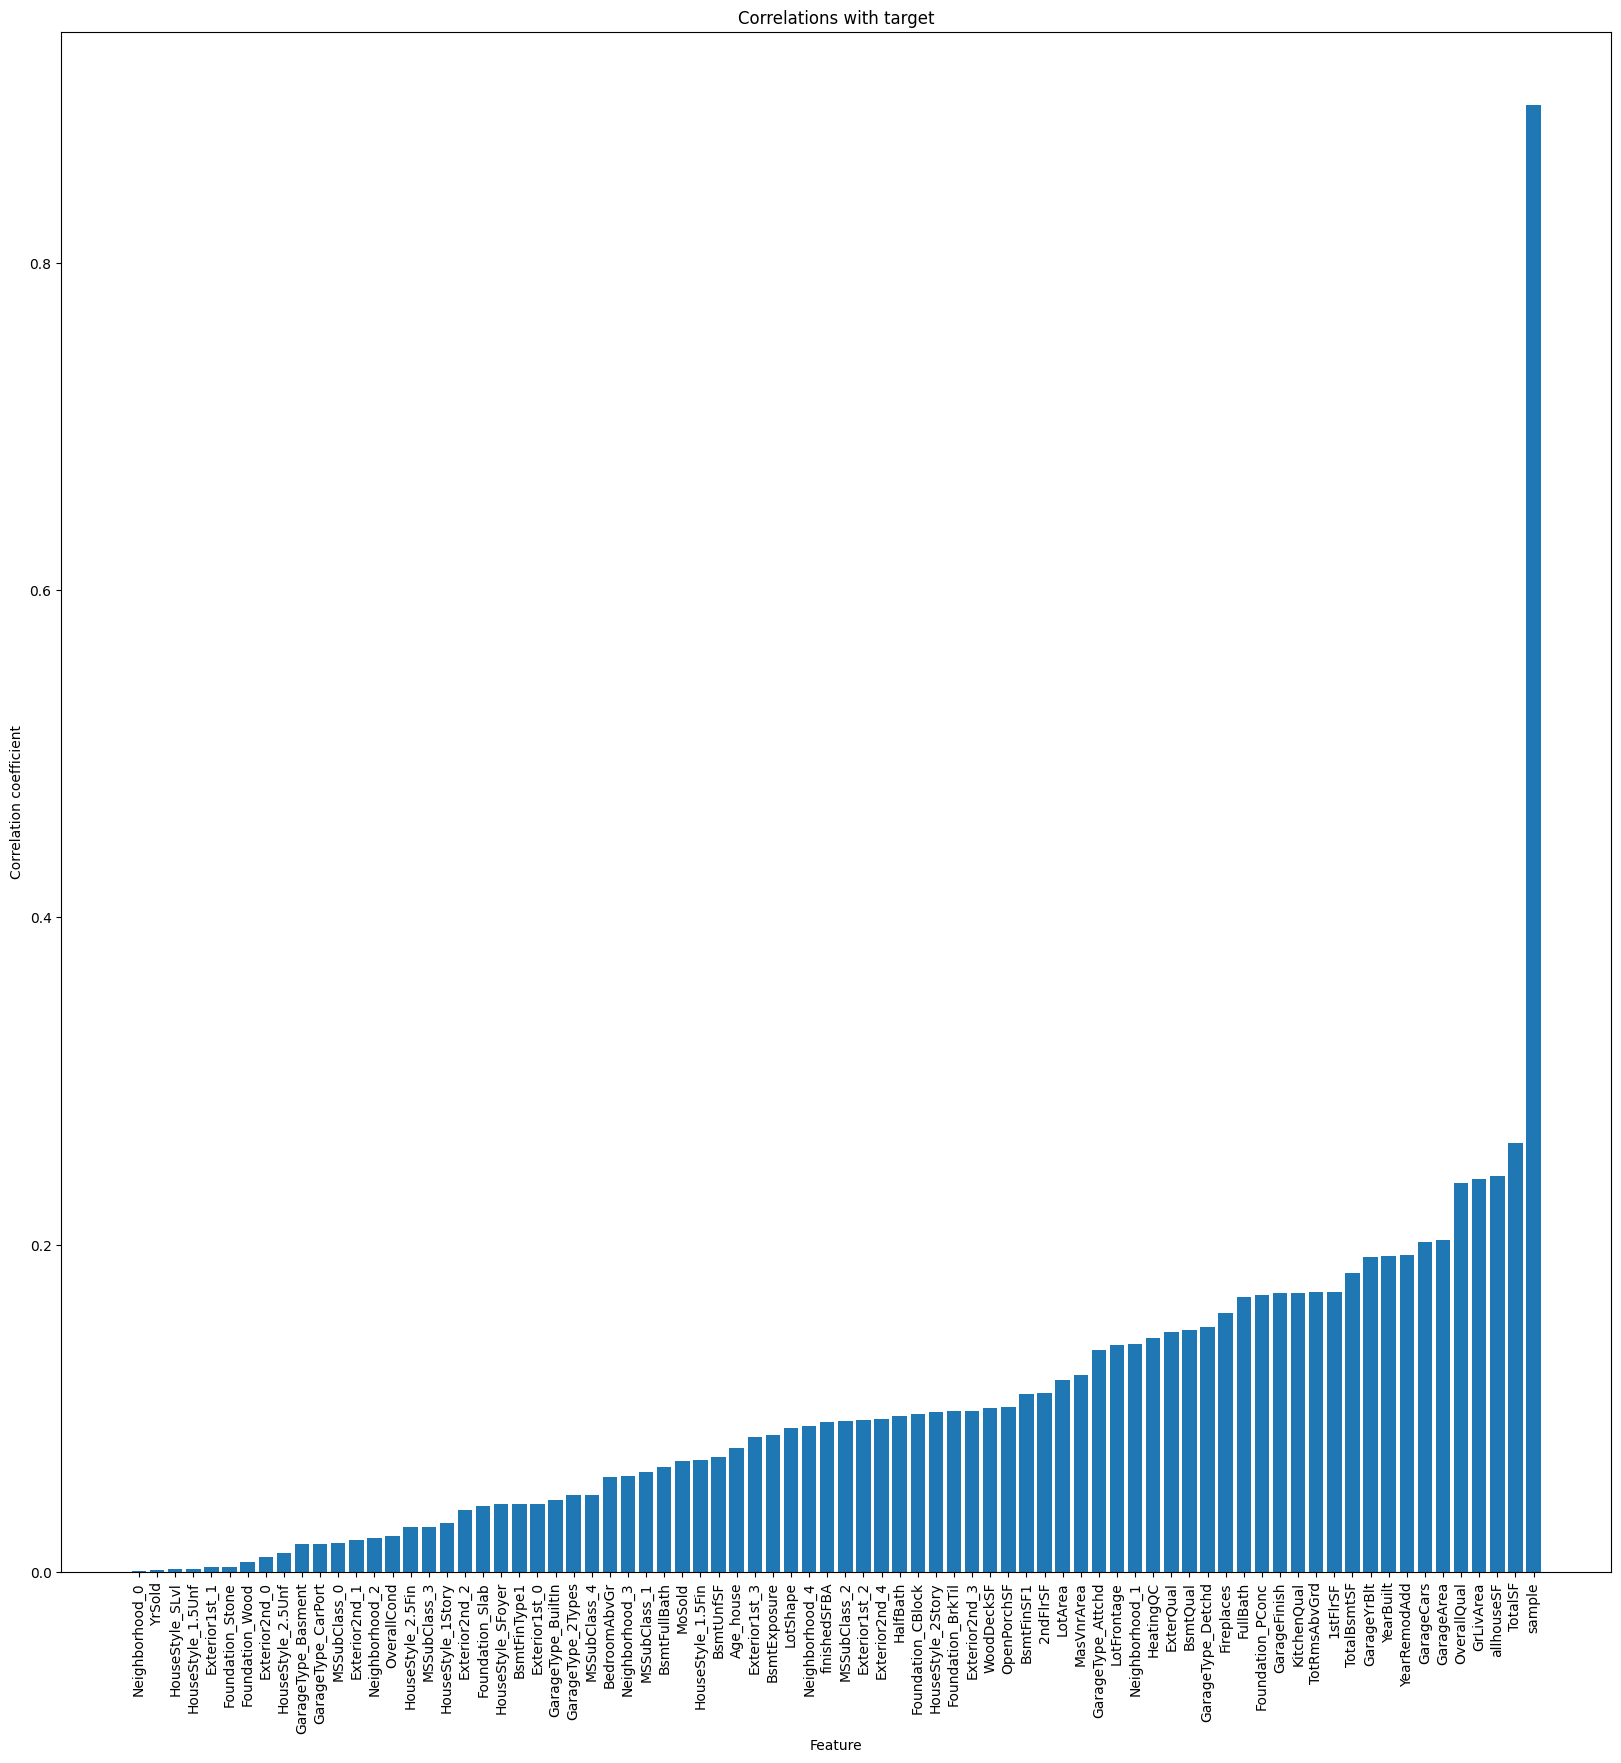

In [49]:
#Calculating the correlation module
corr_with_target = house_df_cleaned.corr()['SalePrice'].abs().sort_values()
#Removing the correlation of the target variable with itself
corr_with_target = corr_with_target.drop('SalePrice')
#Building a bar chart of correlations
fig, ax = plt.subplots(figsize=(20, 20))
ax.bar(corr_with_target.index, corr_with_target.values)
ax.set_title('Correlations with target') 
ax.set_xlabel('Feature')
ax.set_ylabel('Сorrelation coefficient');
ax.xaxis.set_tick_params(rotation=90)

### Calculating correlation pairs

In [50]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

corr_pairs = get_top_abs_correlations(house_df_cleaned, 30)
corr_pairs

GrLivArea          allhouseSF           0.994228
BsmtFinSF1         finishedSFBA         0.929149
SalePrice          sample               0.896188
GarageCars         GarageArea           0.891615
YearBuilt          GarageYrBlt          0.856834
Exterior1st_2      Exterior2nd_3        0.847888
GarageType_Attchd  GarageType_Detchd    0.842683
allhouseSF         TotalSF              0.831815
GrLivArea          TotalSF              0.826199
2ndFlrSF           HouseStyle_2Story    0.824522
TotalBsmtSF        TotalSF              0.795887
2ndFlrSF           HouseStyle_1Story    0.795250
GrLivArea          TotRmsAbvGrd         0.789028
TotRmsAbvGrd       allhouseSF           0.783608
TotalBsmtSF        1stFlrSF             0.773265
Foundation_CBlock  Foundation_PConc     0.764744
1stFlrSF           TotalSF              0.729536
BedroomAbvGr       TotRmsAbvGrd         0.691982
2ndFlrSF           allhouseSF           0.676446
                   GrLivArea            0.672757
LotFrontage        L

### removing features from pairs with too high (multi) correlation

In [51]:
house_df_cleaned = house_df_cleaned.drop(['allhouseSF', '1stFlrSF', 'BsmtFinSF1', 'GarageCars', 'GarageYrBlt'], axis=1)

### Selecting a train sample from the data

In [52]:
house_df = house_df_cleaned.query('sample == 1').drop(['sample'], axis=1)

In [55]:
y = house_df['SalePrice']            # target feature
X = house_df.drop(['SalePrice'], axis=1)

In [57]:
new_test_df = new_test_df.drop('SalePrice', axis=1)

In [59]:
new_test_df = new_test_df.drop(['allhouseSF', '1stFlrSF', 'BsmtFinSF1', 'GarageCars', 'GarageYrBlt'], axis=1)

In [61]:
test_scaler = RobustScaler()
test_scaler.fit(new_test_df)
test_data_scaled = test_scaler.transform(new_test_df)

In [62]:
test_data_scaled

array([[ 0.5       ,  0.5387132 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.55      ,  1.17969223, -1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.2       ,  1.07379135, -1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.5       ,  2.56900521,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.4       ,  0.25251424,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.2       ,  0.05525264,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## Splitting the data into training and test samples and training different models using optuna

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalization
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Polynomial preprocessing
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train_scaled)

X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

# Defining functions for optimizing hyperparameters using Optuna
def objective_lr(trial):
    model = LinearRegression()
    scores = cross_val_score(model, X_train_scaled_poly, y_train, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
    return -scores.mean()

def objective_lasso(trial):
    alpha = trial.suggest_int('alpha', 0.1, 1)
    model = Lasso(alpha=alpha, max_iter=1000, random_state=42)
    scores = cross_val_score(model, X_train_scaled_poly, y_train, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
    return -scores.mean()

def objective_ridge(trial):
    alpha = trial.suggest_int('alpha', 1, 20)
    feat = ['auto', 'svd']
    solver = trial.suggest_categorical('solver', feat)
    model = Ridge(alpha=alpha, solver=solver, max_iter=1000, random_state=42)
    scores = cross_val_score(model, X_train_scaled_poly, y_train, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
    return -scores.mean()

def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 20)
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
    return -scores.mean()

def objective_gb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 20)
    model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
    return -scores.mean()

def objective_xgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 20)
    model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
    return -scores.mean()

def objective_lgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
    model = lgb.LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
    return -scores.mean()

def objective_cbr(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
    depth = trial.suggest_int('depth', 3, 10)
    iterations =  trial.suggest_int('iterations', 300, 600)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10)
    boosting_type = trial.suggest_categorical('boosting_type', ['Ordered', 'Plain'])
    model = CatBoostRegressor(learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_leaf_reg,
                              boosting_type=boosting_type, loss_function='RMSE', 
                              logging_level='Silent', random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
    return -scores.mean()

# Optimization of hyperparameters using Optuna
study_lr = optuna.create_study()
study_lr.optimize(objective_lr, n_trials=30)

study_lasso = optuna.create_study()
study_lasso.optimize(objective_lasso, n_trials=30)

study_ridge = optuna.create_study()
study_ridge.optimize(objective_ridge, n_trials=30)

study_rf = optuna.create_study()
study_rf.optimize(objective_rf, n_trials=30)

study_gb = optuna.create_study()
study_gb.optimize(objective_gb, n_trials=30)

study_xgb = optuna.create_study()
study_xgb.optimize(objective_xgb, n_trials=30)

study_lgb = optuna.create_study()
study_lgb.optimize(objective_lgb, n_trials=30)

study_cbr = optuna.create_study()
study_cbr.optimize(objective_cbr, n_trials=30)

# Fitting models with the best hyperparameters
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(**study_lasso.best_params),
    'Ridge': Ridge(**study_lasso.best_params),
    'Random Forest': RandomForestRegressor(**study_rf.best_params),
    'Gradient Boosting': GradientBoostingRegressor(**study_gb.best_params),
    'XGBoost': XGBRegressor(**study_xgb.best_params),
    'LightGBM': lgb.LGBMRegressor(**study_lgb.best_params),
    'CatBoostRegressor': CatBoostRegressor(**study_cbr.best_params)
}

results = {}

for name, model in models.items():
    if name == 'Linear Regression' or name == 'Lasso' or name == 'Ridge':
        model.fit(X_train_scaled_poly, y_train)
        y_pred = model.predict(X_test_scaled_poly)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    results[name] = {'MSE': mse, 'RMSE': rmse}

# Вывод результатов
for name, metrics in results.items():
    print(f"{name} -> MSE: {metrics['MSE']:.4f}, RMSE: {metrics['RMSE']:.4f}")


[I 2024-11-27 18:35:26,602] A new study created in memory with name: no-name-4c2e60de-9077-4746-a481-988b74519a66
[I 2024-11-27 18:36:20,320] Trial 0 finished with value: 539561164.3233732 and parameters: {}. Best is trial 0 with value: 539561164.3233732.
[I 2024-11-27 18:37:10,883] Trial 1 finished with value: 539561164.3233732 and parameters: {}. Best is trial 0 with value: 539561164.3233732.
[I 2024-11-27 18:38:01,106] Trial 2 finished with value: 539561164.3233732 and parameters: {}. Best is trial 0 with value: 539561164.3233732.
[I 2024-11-27 18:38:52,096] Trial 3 finished with value: 539561164.3233732 and parameters: {}. Best is trial 0 with value: 539561164.3233732.
[I 2024-11-27 18:39:42,971] Trial 4 finished with value: 539561164.3233732 and parameters: {}. Best is trial 0 with value: 539561164.3233732.
[I 2024-11-27 18:40:33,988] Trial 5 finished with value: 539561164.3233732 and parameters: {}. Best is trial 0 with value: 539561164.3233732.
[I 2024-11-27 18:41:24,884] Trial 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2383
[LightGBM] [Info] Number of data points in the train set: 827, number of used features: 61
[LightGBM] [Info] Start training from score 165017.232164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-27 20:20:16,132] Trial 4 finished with value: 457972433.6282364 and parameters: {'n_estimators': 92, 'learning_rate': 0.2605543270989656}. Best is trial 0 with value: 408998128.5673994.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2402
[LightGBM] [Info] Number of data points in the train set: 826, number of used features: 60
[LightGBM] [Info] Start training from score 167189.198547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-27 20:20:17,978] Trial 5 finished with value: 428889442.124596 and parameters: {'n_estimators': 268, 'learning_rate': 0.09296559307434792}. Best is trial 0 with value: 408998128.5673994.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2397
[LightGBM] [Info] Number of data points in the train set: 826, number of used features: 61
[LightGBM] [Info] Start training from score 166407.541162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-27 20:20:19,062] Trial 6 finished with value: 546043592.6422995 and parameters: {'n_estimators': 166, 'learning_rate': 0.012001012349206242}. Best is trial 0 with value: 408998128.5673994.
[I 2024-11-27 20:20:19,649] Trial 7 finished with value: 454199347.2794043 and parameters: {'n_estimators': 78, 'learning_rate': 0.23276260887998276}. Best is trial 0 with value: 408998128.5673994.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-27 20:20:21,403] Trial 8 finished with value: 418690579.35187167 and parameters: {'n_estimators': 264, 'learning_rate': 0.0770713488842721}. Best is trial 0 with value: 408998128.5673994.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2383
[LightGBM] [Info] Number of data points in the train set: 827, number of used features: 61
[LightGBM] [Info] Start training from score 165017.232164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-27 20:20:22,407] Trial 9 finished with value: 662903961.4159815 and parameters: {'n_estimators': 152, 'learning_rate': 0.010088890804308727}. Best is trial 0 with value: 408998128.5673994.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2452
[LightGBM] [Info] Number of data points in the train set: 826, number of used features: 61
[LightGBM] [Info] Start training from score 168649.952785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-27 20:20:23,860] Trial 10 finished with value: 409780647.0502993 and parameters: {'n_estimators': 214, 'learning_rate': 0.030337910201360216}. Best is trial 0 with value: 408998128.5673994.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2399
[LightGBM] [Info] Number of data points in the train set: 827, number of used features: 61
[LightGBM] [Info] Start training from score 168515.667473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-27 20:20:25,394] Trial 11 finished with value: 412384934.6141294 and parameters: {'n_estimators': 220, 'learning_rate': 0.03157023783019013}. Best is trial 0 with value: 408998128.5673994.
[I 2024-11-27 20:20:26,838] Trial 12 finished with value: 411194094.84142137 and parameters: {'n_estimators': 214, 'learning_rate': 0.02713458640001335}. Best is trial 0 with value: 408998128.5673994.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2383
[LightGBM] [Info] Number of data points in the train set: 827, nu

[I 2024-11-27 20:20:28,272] Trial 13 finished with value: 414035746.8421656 and parameters: {'n_estimators': 210, 'learning_rate': 0.049440232008751035}. Best is trial 0 with value: 408998128.5673994.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2397
[LightGBM] [Info] Number of data points in the train set: 826, number of used features: 61
[LightGBM] [Info] Start training from score 166407.541162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-27 20:20:29,573] Trial 14 finished with value: 423980683.2062905 and parameters: {'n_estimators': 196, 'learning_rate': 0.01977008194072891}. Best is trial 0 with value: 408998128.5673994.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

[I 2024-11-27 20:20:31,598] Trial 15 finished with value: 439652251.301493 and parameters: {'n_estimators': 298, 'learning_rate': 0.13428000684560185}. Best is trial 0 with value: 408998128.5673994.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2402
[LightGBM] [Info] Number of data points in the train set: 826, nu

[I 2024-11-27 20:20:32,501] Trial 16 finished with value: 409934083.0016403 and parameters: {'n_estimators': 123, 'learning_rate': 0.051334330986910204}. Best is trial 0 with value: 408998128.5673994.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2383
[LightGBM] [Info] Number of data points in the train set: 827, number of used features: 61
[LightGBM] [Info] Start training from score 165017.232164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-27 20:20:34,126] Trial 17 finished with value: 413808530.6993388 and parameters: {'n_estimators': 242, 'learning_rate': 0.021910096566673348}. Best is trial 0 with value: 408998128.5673994.
[I 2024-11-27 20:20:35,402] Trial 18 finished with value: 410010853.93035364 and parameters: {'n_estimators': 184, 'learning_rate': 0.04056234985148006}. Best is trial 0 with value: 408998128.5673994.
[I 2024-11-27 20:20:36,430] Trial 19 finished with value: 420820702.27736753 and parameters: {'n_estimators': 143, 'learning_rate': 0.07653799721726136}. Best is trial 0 with value: 408998128.5673994.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-27 20:20:37,254] Trial 20 finished with value: 509951437.95194036 and parameters: {'n_estimators': 111, 'learning_rate': 0.0201615194053037}. Best is trial 0 with value: 408998128.5673994.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-27 20:20:38,136] Trial 21 finished with value: 409559773.8263955 and parameters: {'n_estimators': 123, 'learning_rate': 0.05691795537901958}. Best is trial 0 with value: 408998128.5673994.
[I 2024-11-27 20:20:39,346] Trial 22 finished with value: 411949595.0096842 and parameters: {'n_estimators': 173, 'learning_rate': 0.06881428998405158}. Best is trial 0 with value: 408998128.5673994.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-27 20:20:40,289] Trial 23 finished with value: 440168686.3946599 and parameters: {'n_estimators': 130, 'learning_rate': 0.11903012201762063}. Best is trial 0 with value: 408998128.5673994.
[I 2024-11-27 20:20:41,577] Trial 24 finished with value: 412275091.80996764 and parameters: {'n_estimators': 189, 'learning_rate': 0.04673595982415552}. Best is trial 0 with value: 408998128.5673994.
[I 2024-11-27 20:20:42,424] Trial 25 finished with value: 414364001.303998 and parameters: {'n_estimators': 115, 'learning_rate': 0.062341930221213614}. Best is trial 0 with value: 408998128.5673994.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2397
[LightGBM] [Info] Number of data points in the train set: 826, number of used features: 61
[LightGBM] [Info] Start training from score 16640

[I 2024-11-27 20:20:43,987] Trial 26 finished with value: 411151568.02548504 and parameters: {'n_estimators': 234, 'learning_rate': 0.026508097255844167}. Best is trial 0 with value: 408998128.5673994.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2452
[LightGBM] [Info] Number of data points in the train set: 826, number of used features: 61
[LightGBM] [Info] Start training from score 168649.952785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-27 20:20:45,165] Trial 27 finished with value: 408762276.6611953 and parameters: {'n_estimators': 169, 'learning_rate': 0.0395668281186097}. Best is trial 27 with value: 408762276.6611953.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-27 20:20:46,344] Trial 28 finished with value: 424344183.2308337 and parameters: {'n_estimators': 169, 'learning_rate': 0.10329571270900195}. Best is trial 27 with value: 408762276.6611953.
[I 2024-11-27 20:20:46,832] Trial 29 finished with value: 424663314.5892293 and parameters: {'n_estimators': 61, 'learning_rate': 0.1669373046290272}. Best is trial 27 with value: 408762276.6611953.
[I 2024-11-27 20:20:46,833] A new study created in memory with name: no-name-b285cd60-6d79-4f20-b12b-966f33b4f219
[I 2024-11-27 20:21:20,444] Trial 0 finished with value: 401159000.4204238 and parameters: {'learning_rate': 0.19563728131297722, 'depth': 5, 'iterations': 530, 'l2_leaf_reg': 3.829577459761148, 'boosting_type': 'Ordered'}. Best is trial 0 with value: 401159000.4204238.
[I 2024-11-27 20:21:44,698] Trial 1 finished with value: 362129182.85139024 and parameters: {'learning_rate': 0.05070218695607244, 'depth': 7, 'iterations': 558, 'l2_leaf_reg': 4.607166535599615, 'boosting_type': 'P

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2397
[LightGBM] [Info] Number of data points in the train set: 826, number of used features: 61
[LightGBM] [Info] Start training from score 166407.541162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-27 20:23:28,872] Trial 3 finished with value: 394168174.5289124 and parameters: {'learning_rate': 0.013627331140457482, 'depth': 7, 'iterations': 576, 'l2_leaf_reg': 9.123541265816199, 'boosting_type': 'Ordered'}. Best is trial 2 with value: 356481877.98595923.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2399
[LightGBM] [Info] Number of data points in the train set: 827, number of used features: 61
[LightGBM] [Info] Start training from score 168515.667473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-27 20:25:39,662] Trial 4 finished with value: 467333595.6973564 and parameters: {'learning_rate': 0.16850600376843997, 'depth': 10, 'iterations': 435, 'l2_leaf_reg': 5.4562484085013505, 'boosting_type': 'Plain'}. Best is trial 2 with value: 356481877.98595923.
[I 2024-11-27 20:25:53,423] Trial 5 finished with value: 352380164.66392237 and parameters: {'learning_rate': 0.11676447234719828, 'depth': 5, 'iterations': 491, 'l2_leaf_reg': 9.20808877770593, 'boosting_type': 'Plain'}. Best is trial 5 with value: 352380164.66392237.
[I 2024-11-27 20:26:06,017] Trial 6 finished with value: 333054978.1091505 and parameters: {'learning_rate': 0.033411205487356536, 'depth': 5, 'iterations': 411, 'l2_leaf_reg': 1.1905500213118476, 'boosting_type': 'Plain'}. Best is trial 6 with value: 333054978.1091505.
[I 2024-11-27 20:29:19,908] Trial 7 finished with value: 377116975.59937155 and parameters: {'learning_rate': 0.041400693273217534, 'depth': 8, 'iterations': 445, 'l2_leaf_reg': 2.4281773

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2648
[LightGBM] [Info] Number of data points in the train set: 1033, number of used features: 62
[LightGBM] [Info] Start training from score 167155.729913
0:	learn: 57562.5774711	total: 49.5ms	remaining: 20.3s
1:	learn: 56308.2070321	total: 51.5ms	remaining: 10.5s
2:	learn: 54997.6070107	total: 53.3ms	remaining: 7.24s
3:	learn: 53802.6429010	total: 55.1ms	remaining: 5.6s
4:	learn: 52660.7161511	total: 56.8ms	remaining: 4.61s
5:	learn: 51570.6442142	total: 58.5ms	remaining: 3.95s
6:	learn: 50448.9253286	total: 60.2ms	remaining: 3.48s
7:	learn: 49310.2938913	total: 61.9ms	remaining: 3.12s
8:	learn: 48313.7795794	total: 63.5ms	remaining: 2.84s
9:	learn: 47300.5900509	total: 65.1ms	remaining: 2.61s
10:	learn: 46380.2518352	total: 66.8ms	re

In [66]:
for name, model in models.items():
    if name == 'CatBoostRegressor':
        print(model.get_params())
        model.get_params()

{'iterations': 411, 'learning_rate': 0.033411205487356536, 'depth': 5, 'l2_leaf_reg': 1.1905500213118476, 'loss_function': 'RMSE', 'boosting_type': 'Plain'}


In [67]:
models

{'Linear Regression': LinearRegression(),
 'Lasso': Lasso(alpha=1),
 'Ridge': Ridge(alpha=1),
 'Random Forest': RandomForestRegressor(max_depth=16, min_samples_leaf=2, n_estimators=195),
 'Gradient Boosting': GradientBoostingRegressor(learning_rate=0.22523664985896683, max_depth=1,
                           min_samples_leaf=6, n_estimators=296),
 'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.21113154131887707,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, min_samples_leaf=12, missing=nan,
     

## Training data on the best model, and checking the metrics again

In [70]:
cbr = CatBoostRegressor(iterations= 334, learning_rate= 0.07686292918300291, depth= 5,
                        l2_leaf_reg= 2.349039898942043, loss_function= 'RMSE', 
                        boosting_type= 'Plain', random_state=42)
# Обучаем модель
cbr.fit(X_train_scaled, y_train)
# Формируем предсказание для тестовой выборки
y_pred_cbr = cbr.predict(X_test_scaled)
# Посмотрим на основные метрики классификации
r2 = r2_score(y_test, y_pred_cbr)
mse = mean_squared_error(y_test, y_pred_cbr)
rmse = np.sqrt(mse)
print(r2)
print(mse)
print(rmse)

0:	learn: 55926.9704090	total: 2.76ms	remaining: 920ms
1:	learn: 53123.7566769	total: 5.25ms	remaining: 872ms
2:	learn: 50454.1024699	total: 7.28ms	remaining: 803ms
3:	learn: 48024.9753555	total: 9.38ms	remaining: 774ms
4:	learn: 45802.5543421	total: 11.2ms	remaining: 736ms
5:	learn: 43595.7467990	total: 13ms	remaining: 710ms
6:	learn: 41650.4328359	total: 14.7ms	remaining: 688ms
7:	learn: 39965.3803577	total: 16.5ms	remaining: 673ms
8:	learn: 38362.2492153	total: 18.2ms	remaining: 656ms
9:	learn: 36854.8253363	total: 19.9ms	remaining: 644ms
10:	learn: 35388.6897269	total: 21.6ms	remaining: 634ms
11:	learn: 34273.5017482	total: 23.3ms	remaining: 625ms
12:	learn: 33240.0857221	total: 25ms	remaining: 617ms
13:	learn: 32163.6693967	total: 26.7ms	remaining: 611ms
14:	learn: 31143.9476579	total: 28.4ms	remaining: 604ms
15:	learn: 30177.9575997	total: 30.1ms	remaining: 599ms
16:	learn: 29344.2145257	total: 31.8ms	remaining: 594ms
17:	learn: 28481.2296141	total: 33.6ms	remaining: 590ms
18:	le

### Highlighting most inportant features

In [71]:
estimator = cbr
selector = RFE(estimator, n_features_to_select=10, step=1)
selector = selector.fit(X_train_scaled, y_train)
 
selector.get_feature_names_out()

0:	learn: 55926.9704090	total: 2.16ms	remaining: 719ms
1:	learn: 53123.7566769	total: 4.68ms	remaining: 777ms
2:	learn: 50454.1024699	total: 6.32ms	remaining: 697ms
3:	learn: 48024.9753555	total: 8.13ms	remaining: 670ms
4:	learn: 45802.5543421	total: 9.84ms	remaining: 647ms
5:	learn: 43595.7467990	total: 11.7ms	remaining: 638ms
6:	learn: 41650.4328359	total: 13.4ms	remaining: 625ms
7:	learn: 39965.3803577	total: 15.1ms	remaining: 614ms
8:	learn: 38362.2492153	total: 16.8ms	remaining: 608ms
9:	learn: 36854.8253363	total: 18.6ms	remaining: 603ms
10:	learn: 35388.6897269	total: 20.5ms	remaining: 602ms
11:	learn: 34273.5017482	total: 22.4ms	remaining: 600ms
12:	learn: 33240.0857221	total: 24.1ms	remaining: 595ms
13:	learn: 32163.6693967	total: 25.8ms	remaining: 590ms
14:	learn: 31143.9476579	total: 27.6ms	remaining: 587ms
15:	learn: 30177.9575997	total: 29.4ms	remaining: 584ms
16:	learn: 29344.2145257	total: 31.1ms	remaining: 579ms
17:	learn: 28481.2296141	total: 32.9ms	remaining: 578ms
18

array(['x1', 'x3', 'x4', 'x5', 'x6', 'x16', 'x24', 'x25', 'x31', 'x32'],
      dtype=object)

### Visualization of the most important features

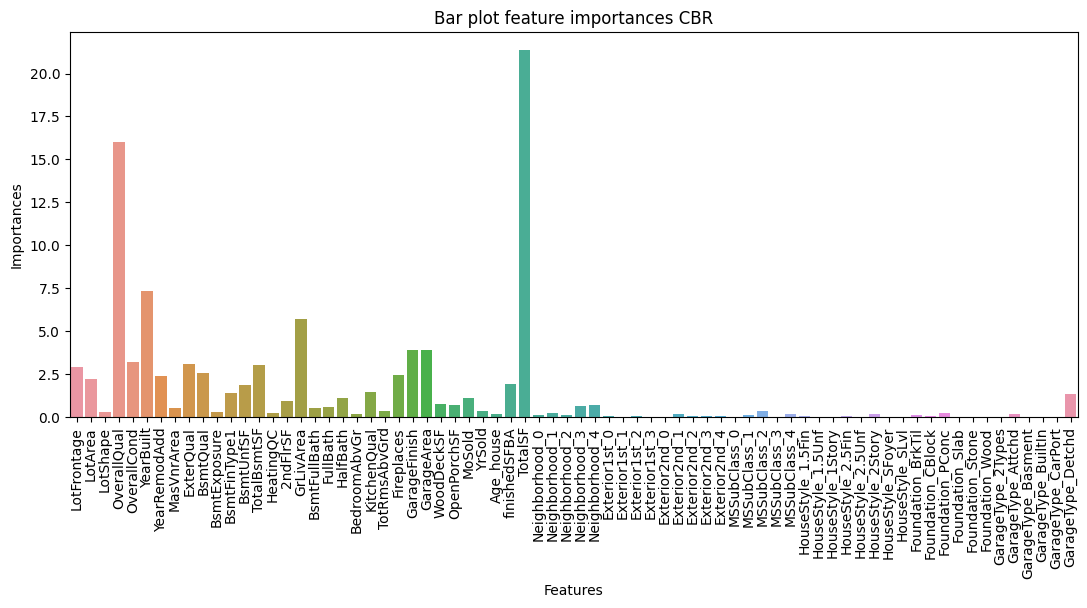

In [72]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X_train.columns 
feature_importances = cbr.feature_importances_

sns.barplot(x=feature, y=feature_importances, ax=ax);
ax.set_title('Bar plot feature importances CBR')
ax.set_xlabel('Features')
ax.set_ylabel('Importances')
plt.xticks(rotation = 90);

In [73]:
X_test_scaled.shape

(259, 72)

In [74]:
test_data_scaled

array([[ 0.5       ,  0.5387132 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.55      ,  1.17969223, -1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.2       ,  1.07379135, -1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.5       ,  2.56900521,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.4       ,  0.25251424,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.2       ,  0.05525264,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

# The final prediction

In [75]:
pred_cbr = cbr.predict(test_data_scaled)

In [76]:
house_ID = test_df['Id']

In [77]:
output = pd.DataFrame({'Id': house_ID, 'SalePrice': pred_cbr})

In [78]:
output

Id      SalePrice
0     1461  130634.635615
1     1462  164553.318695
2     1463  180407.888917
3     1464  196310.305630
4     1465  170319.249613
...    ...            ...
1454  2915   90591.446308
1455  2916   87022.277732
1456  2917  170473.181985
1457  2918  119234.426381
1458  2919  213723.622047

[1459 rows x 2 columns]

In [79]:
output.to_csv('CBR_submis_Z_Robust.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
